In [1]:
import os
import sys
import babeltrace
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython.display import display, clear_output

sys.path.append("/home/adlink/ros2-workspace/install/tracetools_read/lib/python3.8/site-packages/")
sys.path.append("/home/adlink/ros2-workspace/src/tracetools_analysis/tracetools_analysis/")
from tracetools_read.trace import *
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [2]:
path = os.path.expanduser("~/.ros/tracing/autoware-trace/")
file = load_file(path)

found converted file: /home/adlink/.ros/tracing/autoware-trace/converted


In [3]:
handler = Ros2Handler.process(file)


 [100%] [Ros2Handler]


In [4]:

self = handler.data
n=1
print('====================ROS 2 DATA MODEL===================')
print('Contexts:')
print(self.contexts[:n].to_string())
print('Nodes:')
print(self.nodes[:n].to_string())
print('Publishers (rmw):')
print(self.rmw_publishers[:n].to_string())
print('Publishers (rcl):')
print(self.rcl_publishers[:n].to_string())
print('Subscriptions (rmw):')
print(self.rmw_subscriptions[:n].to_string())
print('Subscriptions (rcl):')
print(self.rcl_subscriptions[:n].to_string())
print('Subscription objects:')
print(self.subscription_objects[:n].to_string())
print('Services:')
print(self.services[:n].to_string())
print('Clients:')
print(self.clients[:n].to_string())
print('Timers:')
print(self.timers[:n].to_string())
print('Timer-node links:')
print(self.timer_node_links[:n].to_string())
print('Callback objects:')
print(self.callback_objects[:n].to_string())
print('Callback symbols:')
print(self.callback_symbols[:n].to_string())
print('Callback instances:')
print(self.callback_instances[:n].to_string())
print('Publish instances (rclcpp):')
print(self.rclcpp_publish_instances[:n].to_string())
print('Publish instances (rcl):')
print(self.rcl_publish_instances[:n].to_string())
print('Publish instances (rmw):')
print(self.rmw_publish_instances[:n].to_string())
print('Take instances (rmw):')
print(self.rmw_take_instances[:n].to_string())
print('Take instances (rcl):')
print(self.rcl_take_instances[:n].to_string())
print('Take instances (rclcpp):')
print(self.rclcpp_take_instances[:n].to_string())
print('Lifecycle state machines:')
print(self.lifecycle_state_machines[:n].to_string())
print('Lifecycle transitions:')
print(self.lifecycle_transitions[:n].to_string())
print('==================================================')


====================ROS 2 DATA MODEL===================
Contexts:
                          timestamp   pid version
context_handle                                   
578889920       1652795531158728529  9807   2.3.0
Nodes:
                       timestamp   tid  rmw_handle             name namespace
node_handle                                                                  
578605264    1652795531205345494  9807   578658512  launch_ros_9807         /
Publishers (rmw):
Empty DataFrame
Columns: []
Index: []
Publishers (rcl):
                            timestamp  node_handle  rmw_handle topic_name  depth
publisher_handle                                                                
281474154018016   1652795531205338094    578605264   580193376    /rosout   1000
Subscriptions (rmw):
Empty DataFrame
Columns: []
Index: []
Subscriptions (rcl):
                               timestamp      node_handle       rmw_handle         topic_name  depth
subscription_handle                          

# Data Structures

In [15]:
from dataclasses import dataclass
from typing import List, Dict

def str_to_cls(classname):
    return getattr(sys.modules[__name__], classname)

def row_to_type(row, type, has_idx):
    return type(id=row.name, **row) if has_idx else type(**row)

def df_to_type_list(df, type):
    if isinstance(type, str):
        type = str_to_cls(type)
        
    has_idx = not isinstance(df.index, pd.RangeIndex)
    return [row_to_type(row, type, has_idx) for _, row in df.iterrows()]

def by_index(df, index, type):
    return df_to_type_list(df.loc[index], type)

def by_column(df, column_name, column_val, type):
    return df_to_type_list(df[df[column_name] == column_val], type)

def list_to_dict(ls, key='id'):
    return {getattr(item, key): item for item in ls}

#################################
# Predefined (from ROS2DataModel)
#################################

@dataclass
class Node:
    id: int
    timestamp: int
    tid: int
    rmw_handle: int
    name: str
    namespace: str

    @property
    def path(self) -> str:
        return os.path.join(self.namespace, self.name)

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.node_handle == self.id, publishers.values()))

    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.node_handle == self.id, subscriptions.values()))
    
    @property
    def timers(self) -> List['Timer']:
        links = [link.id for link in timer_node_links.values() if link.node_handle == self.id]
        return list(filter(lambda timer: timer.id in links, timers.values()))

@dataclass
class Publisher:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.topic_name, subscriptions.values()))

    @property
    def instances(self) -> List['PublishInstance']:
        return list(filter(lambda inst: inst.publisher_handle == self.id, publish_instances))
    
    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]


@dataclass
class Subscription:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.topic_name, publishers.values()))

    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]
    
@dataclass
class Timer:
    id: int
    timestamp: int
    period: int
    tid: int

    @property
    def nodes(self) -> List['Node']:
        links = [link.node_handle for link in timer_node_links.values() if link.id == self.id]
        return list(filter(lambda node: node.id in links, nodes.values()))

@dataclass
class TimerNodeLink:
    id: int
    timestamp: int
    node_handle: int

@dataclass
class SubscriptionObject:
    id: int             # subscription
    timestamp: int
    subscription_handle: int

    @property
    def subscription(self) -> 'Subscription':
        return subscriptions[self.subscription_handle]

@dataclass
class CallbackObject:
    id: int             # (reference) = subscription_object.id
    timestamp: int
    callback_object: int

    @property
    def subscription_object(self) -> 'SubscriptionObject':
        return subscription_objects[self.id]

    @property
    def callback_instances(self) -> List['CallbackInstance']:
        return list(filter(lambda inst: inst.callback_object == self.id, callback_instances))

@dataclass
class PublishInstance:
    publisher_handle: int
    timestamp: int
    message: int

    @property
    def publisher(self) -> 'Publisher':
        return publishers[self.publisher_handle]

@dataclass
class CallbackInstance:
    callback_object: int
    timestamp: int
    duration: int
    intra_process: bool

    @property
    def callback_obj(self) -> 'CallbackObject':
        return callback_objects[self.callback_object]

#######################################
# Self-defined (not from ROS2DataModel)
#######################################

@dataclass
class Topic:
    name: str

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.name, publishers.values()))
    
    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.name, subscriptions.values()))

#######################################
# Instantiate collections
#######################################

nodes:                  Dict[int, 'Node']               = list_to_dict(df_to_type_list(handler.data.nodes,                  'Node'));               print(f"Processed {len(nodes):<8d} nodes")
publishers:             Dict[int, 'Publisher']          = list_to_dict(df_to_type_list(handler.data.rcl_publishers,         'Publisher'));          print(f"Processed {len(publishers):<8d} publishers")
subscriptions:          Dict[int, 'Subscription']       = list_to_dict(df_to_type_list(handler.data.rcl_subscriptions,      'Subscription'));       print(f"Processed {len(subscriptions):<8d} subscriptions")
timers:                 Dict[int, 'Timer']              = list_to_dict(df_to_type_list(handler.data.timers,                 'Timer'));              print(f"Processed {len(timers):<8d} timers")
timer_node_links:       Dict[int, 'TimerNodeLink']      = list_to_dict(df_to_type_list(handler.data.timer_node_links,       'TimerNodeLink'));      print(f"Processed {len(timer_node_links):<8d} timer-node links")
subscription_objects:   Dict[int, 'SubscriptionObject'] = list_to_dict(df_to_type_list(handler.data.subscription_objects,   'SubscriptionObject')); print(f"Processed {len(subscription_objects):<8d} subscription objects")
callback_objects:       Dict[int, 'CallbackObject']     = list_to_dict(df_to_type_list(handler.data.callback_objects,       'CallbackObject'));     print(f"Processed {len(callback_objects):<8d} callback objects")
publish_instances:      List['PublishInstance']         =              df_to_type_list(handler.data.rcl_publish_instances,  'PublishInstance');     print(f"Processed {len(publish_instances):<8d} publish instances")
callback_instances:     List['CallbackInstance']        =              df_to_type_list(handler.data.callback_instances,     'CallbackInstance');    print(f"Processed {len(callback_instances):<8d} callback instances")

_unique_topic_names = {*(pub.topic_name for pub in publishers.values()), *(sub.topic_name for sub in subscriptions.values())}
topics: Dict[str, 'Topic'] = list_to_dict(map(Topic, _unique_topic_names), key="name"); print(f"Processed {len(topics):<8d} topics")

Processed 61     nodes
Processed 264    publishers
Processed 212    subscriptions
Processed 67     timers
Processed 31     timer-node links
Processed 201    subscription objects
Processed 483    callback objects
Processed 183512 publish instances
Processed 390810 callback instances
Processed 161    topics


[PublishInstance(publisher_handle=580257728, timestamp=1652795531226289729, message=580728240)]

# Topic-Node Mapping

In [23]:
# Aggregate topics that have the same pubs and subs
topic_cohorts = {}
for topic in topics.values():
    key = (frozenset({*(pub.node_handle for pub in topic.publishers)}), frozenset({*(sub.node_handle for sub in topic.subscriptions)}))
    if key not in topic_cohorts:
        topic_cohorts[key] = []
    topic_cohorts[key].append(topic)

print(f"{len(topics)} topics were aggregated into {len(topic_cohorts)} cohorts")

161 topics were aggregated into 78 cohorts


# Timer-Node Mapping

In [24]:
unknowns = {}

print_node_timer = lambda node_path, period: print(f"{node_path:<90s}: {1/(period*1e-9):8.2f}Hz")

for timer in timers.values():
    timer_nodes = timer.nodes
    if not timer_nodes:
        if timer.period not in unknowns:
            unknowns[timer.period] = 0
        unknowns[timer.period] += 1

    for node in timer_nodes: print_node_timer(node.path, timer.period)
        
for period, count in unknowns.items():
    print_node_timer(f"UNKNOWN (x{count})", period)

n_unknown = sum(unknowns.values())  # Values are counts per period
print(f"Found {len(timers) - n_unknown} timers with a recorded node, {n_unknown} without.")

/system/system_error_monitor                                                              :    10.00Hz
/system/emergency_handler                                                                 :    10.00Hz
/system/ad_service_state_monitor                                                          :     1.00Hz
/planning/scenario_planning/scenario_selector                                             :    10.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :     1.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :    10.00Hz
/system/system_monitor/cpu_monitor                                                        :     1.00Hz
/system/system_monitor/hdd_monitor                                                        :     1.00Hz
/control/trajectory_follower/lateral_controller_node_exe                                  :    33.33Hz
/system/system_monitor/hdd_monitor                                       

# Measure Frequency Deviations

In [22]:
# Get Publisher frequencies
df_publications = handler.data.rcl_publish_instances
pub_stats = {}
unknown = 0
for pi in publish_instances:
    try:
        pub = pi.publisher
    except KeyError:
        unknown += 1
        continue
    if pub.id not in pub_stats:
        pub_stats[pub.id] = {'times': []}
    pub_stats[pub.id]['times'].append(pi.timestamp*1e-9) # Nanoseconds to seconds float

print(f"{unknown} unknown publisher handles ({len(pub_stats)} known ones)")

219 unknown publisher handles (176 known ones)


# Plot Frequency Deviations

In [ ]:
fig_dirname = "fig_frequency"
os.makedirs(fig_dirname, exist_ok=True)
for i, (k, v) in enumerate(sorted(pub_stats.items(), key=lambda kv: len(kv[1]['times']), reverse=True)):
    pub_time_diff = np.diff(np.array(v['times']))
    v['period'] = pub_time_diff.mean()
    v['period_std'] = pub_time_diff.std()
    v['frequency'] = 1 / v['period']
    v['frequency_std'] = (1/pub_time_diff).std()

    try:
        publisher = publishers[k]
        publisher_node = publisher.node
        topic_name = publisher.topic_name
        node_path = publisher_node.path
    except Exception:
        topic_name="UNKNOWN"
        node_path="UNKNOWN"
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.hist(1/pub_time_diff)
    ax.set_xlabel("Publication Frequency [Hz]")
    ax.set_ylabel("#Publications")
    ax.set_title(f"{node_path} =({v['frequency']:.2f}Hz)=> {topic_name}")
    plt.savefig(os.path.join(fig_dirname, f"{i:06}{node_path}__{topic_name}".replace('/','-')))


# Data Flow Graph

In [26]:
node_filters = ["transform_listener_impl", "_monitor"]
topic_filters = ["/rosout", "/parameter_events", "/diagnostics"]

from pyvis.network import Network
net = Network(notebook=True, height='750px', width='100%', bgcolor='#ffffff', font_color='#000000')

net.add_node("INPUT", label="Input", size=100, color="green", physics=False, x=0, y=0)
net.add_node("OUTPUT", label="Output", size=100, color="red", physics=False, x=6000, y=0)


for node in nodes.values():
    if any(f in node.name for f in node_filters): 
        continue
    net.add_node(node.id, label=node.name, size=20, color="#333")

for cohort_key, cohort_topics in topic_cohorts.items():
    cohort_topic_names = [topic.name for topic in cohort_topics if not any(f in topic.name for f in topic_filters)]
    if not cohort_topic_names: 
        continue
    cohort_id="\n".join(cohort_topic_names)
    cohort_weight=len(cohort_topic_names)
    net.add_node(cohort_id, label=" ", title=cohort_id, size=5, color="#333")
    
    pubs = cohort_key[0]
    subs = cohort_key[1]
    n_pubs = len(pubs)
    n_subs = len(subs)
    
    try:
        if not n_pubs:
            net.add_edge("INPUT", cohort_id, arrows="to", color="green", weight=cohort_weight)
        if not n_subs:
            net.add_edge(cohort_id, "OUTPUT", arrows="to", color="red", weight=cohort_weight)

        for pub in pubs:
            net.add_edge(pub, cohort_id, arrows="to", color="green", weight=cohort_weight)
        for sub in subs:
            net.add_edge(cohort_id, sub, arrows="to", color="red", weight=cohort_weight)
    except:
        continue

net.toggle_physics(True)
net.show_buttons()
net.show("graph.html")

# Pub-Use Latencies
Compute for each node and its data dependencies the list of pub-use delays (per-topic-per-node list of pub-use delays)

In [ ]:
pub_use_delays = {node.path: {'pubs': {}, 'n_unknown_invocations': 0} for node in nodes.values()}

for node in nodes.values():
    node_path = node.path

    timestamp_min = np.inf; timestamp_max = 0

    for sub in node.subscriptions:
        pub_use_delays[node_path]['pubs'][sub.topic_name] = {}
        for pub in sub.publishers:
            pub_timestamps = [inst.timestamp for inst in pub.instances]

            try:
                pub_t_min = min(pub_timestamps); pub_t_max = max(pub_timestamps)
            except ValueError:
                pub_t_min = np.inf; pub_t_max = 0
            
            if pub_t_min < timestamp_min: timestamp_min = pub_t_min
            if pub_t_max > timestamp_max: timestamp_max = pub_t_max

            pub_use_delays[node_path]['pubs'][sub.topic_name][pub.node.path] = pub_timestamps
    
    t = node.timers
    node_invocations = []
    if t:
        if len(t) == 1:
            trigger_str = "single timer "
        else:
            trigger_str = f"{len(t)} timers"

        for timer in t:
            timer_invocations: np.ndarray = np.arange(timer.timestamp, timestamp_max, timer.period)
            node_invocations += timer_invocations.tolist()
    else:
        trigger_str = f"{len(node.subscriptions)} subscriptions"
        for sub in node.subscriptions:
            try:
                for cb_inst in filter(lambda inst: inst.callback_obj.subscription_object.id == sub.id, callback_instances):
                    node_invocations.append(cb_inst.timestamp)
            except KeyError:
                pub_use_delays[node_path]['n_unknown_invocations'] += 1
                continue
    
    pub_use_delays[node_path]['invocations'] = node_invocations


Skipping /planning/scenario_planning/lane_driving/behavior_planning/transform_listener_impl_ffff24598628, no publications


<ipython-input-54-7f29df84f629>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))


Skipping /planning/scenario_planning/lane_driving/behavior_planning/transform_listener_impl_ffff24598628, no publications
Skipping /planning/scenario_planning/lane_driving/behavior_planning/transform_listener_impl_ffff24598628, no publications


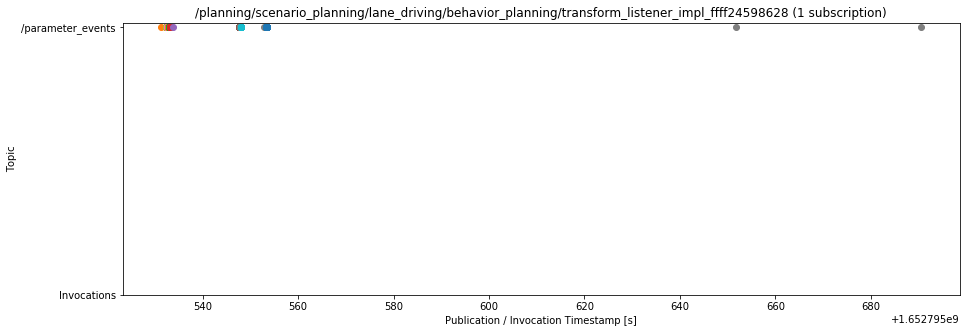

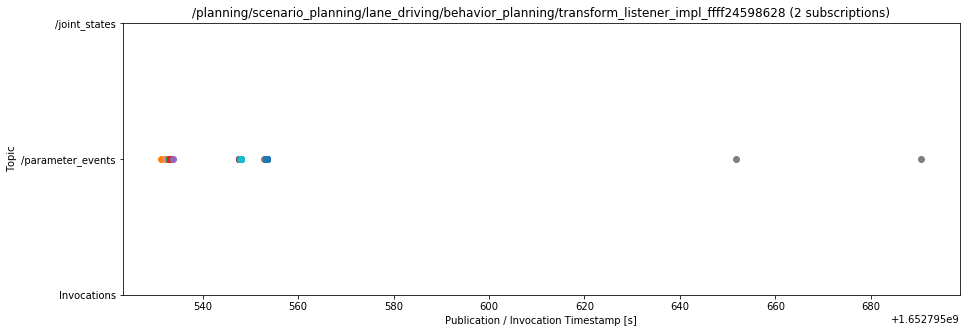

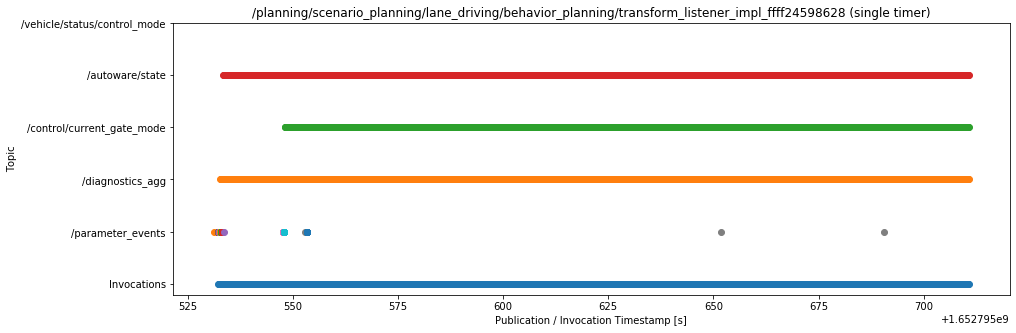

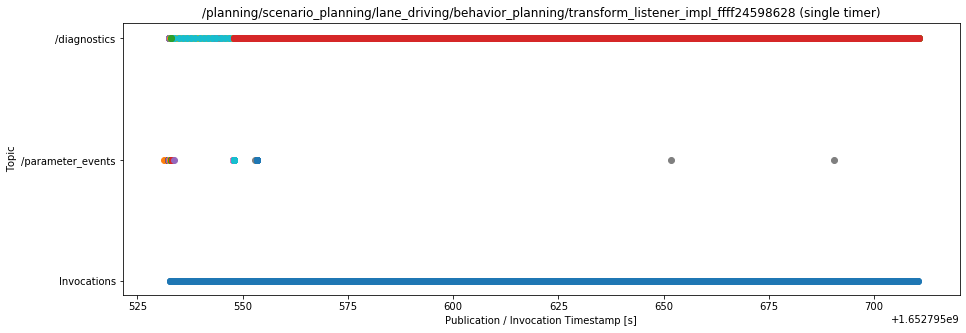

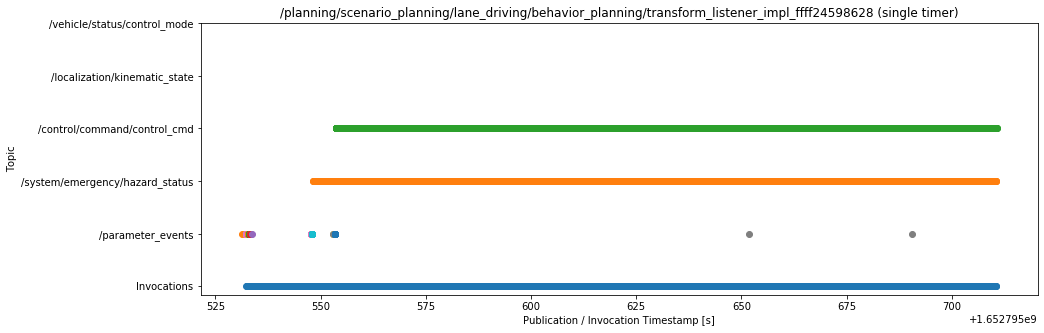

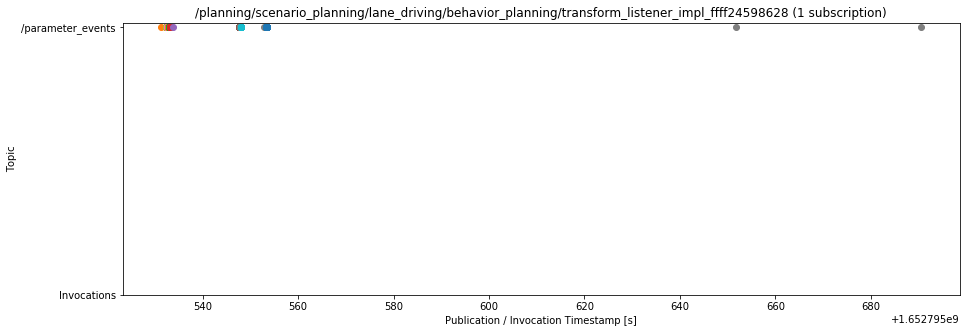

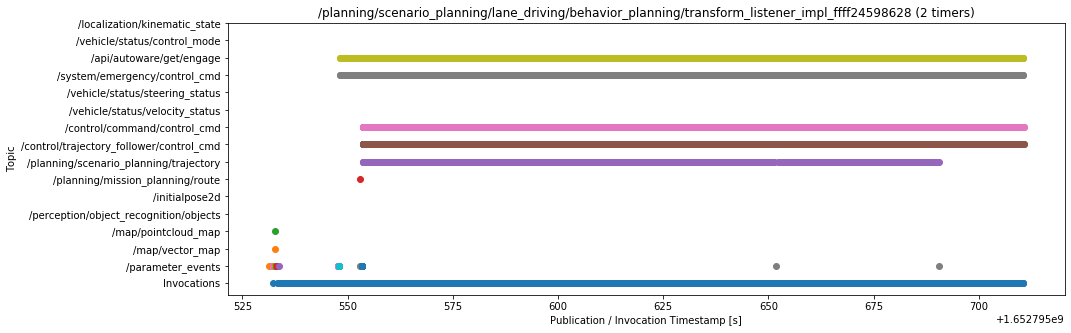

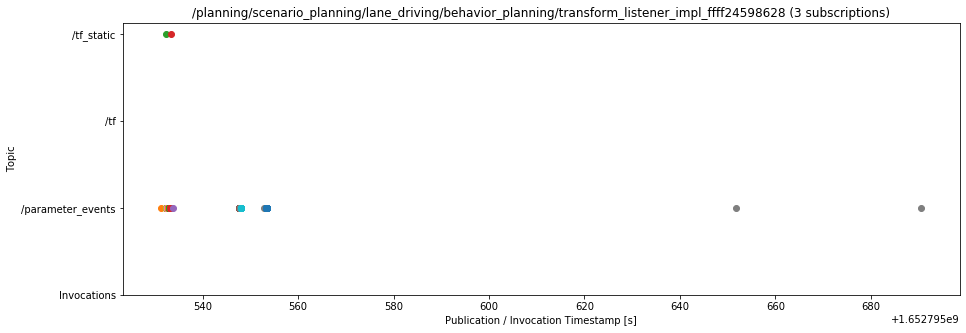

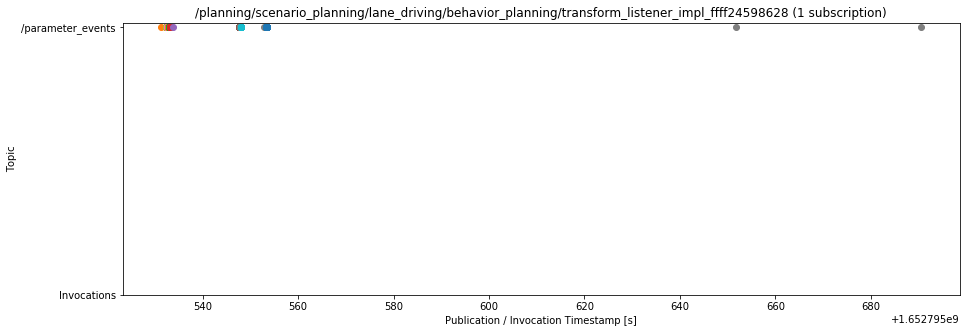

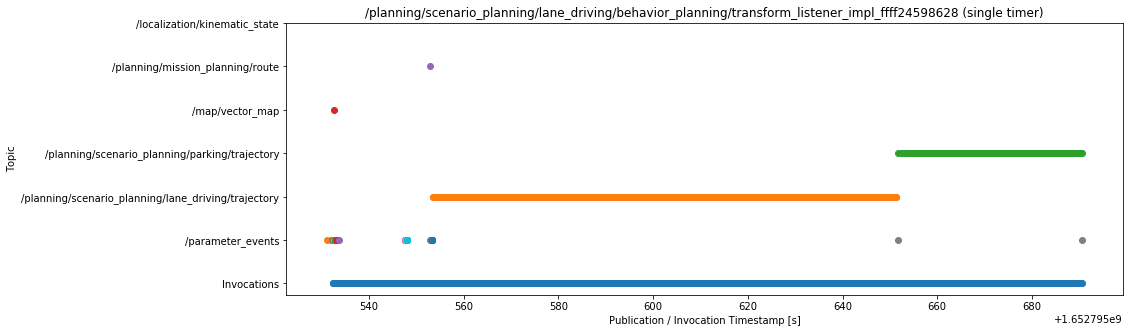

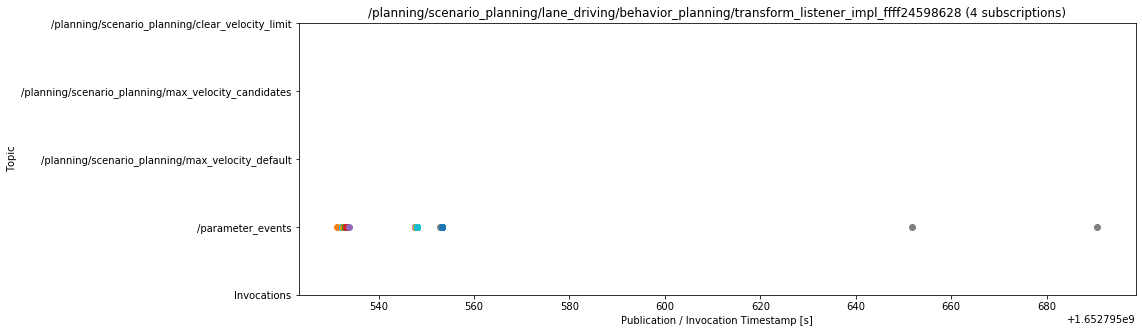

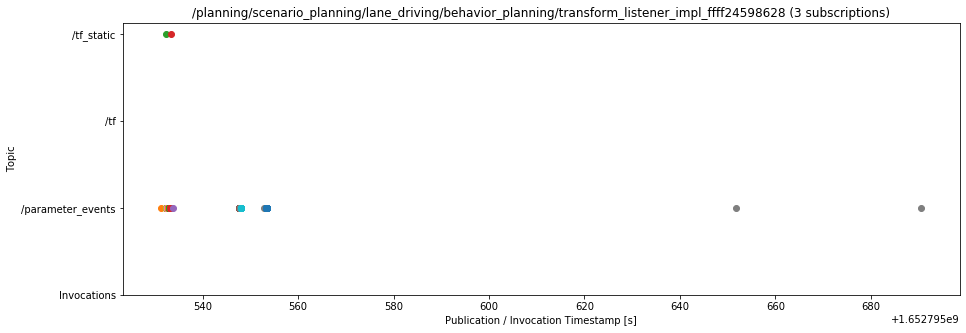

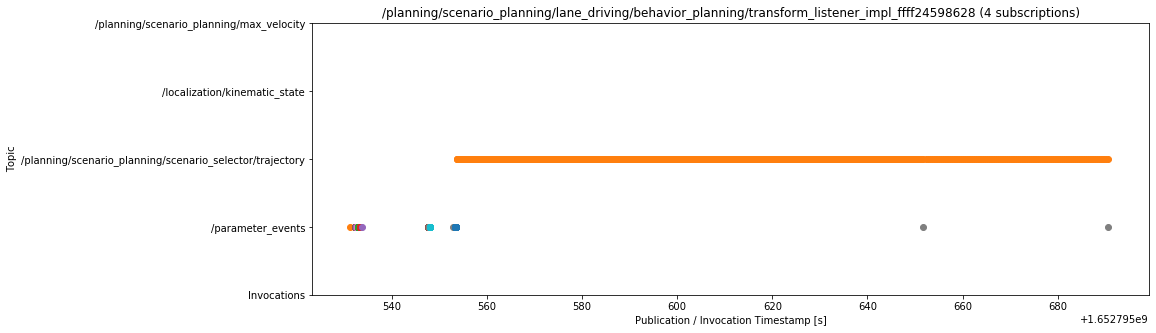

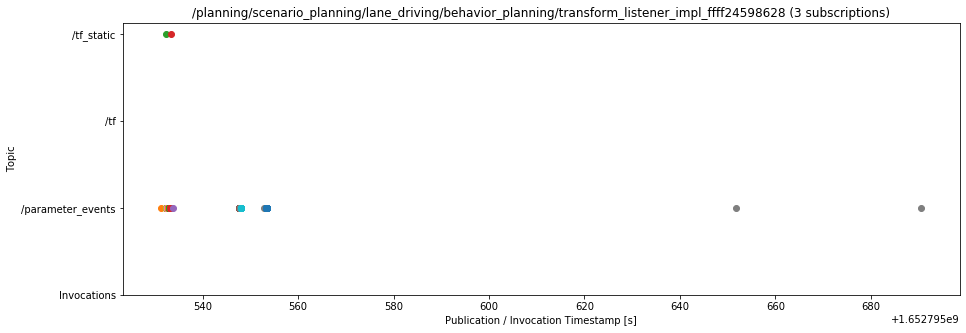

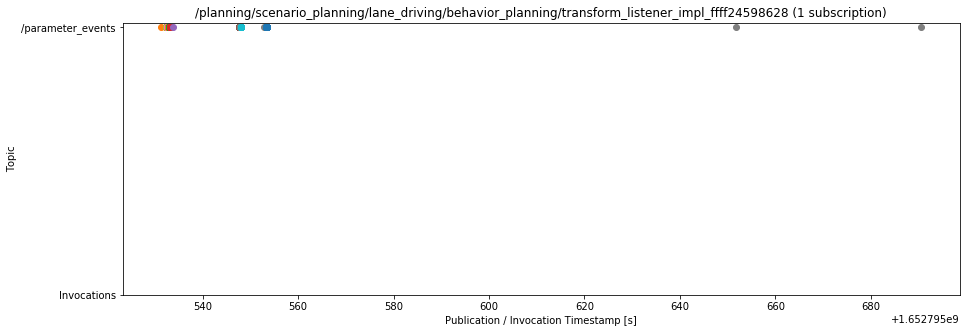

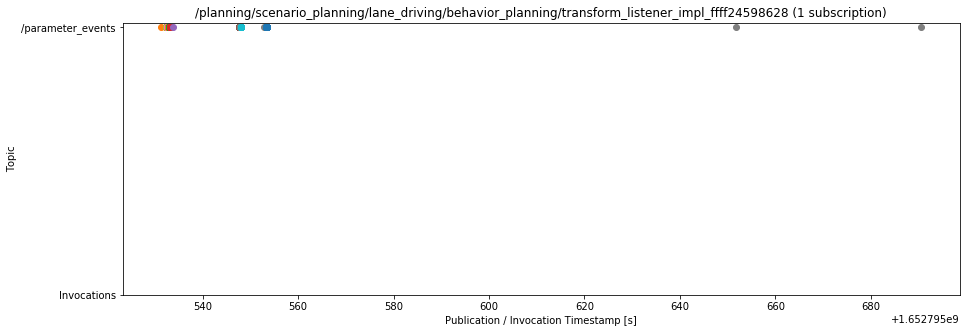

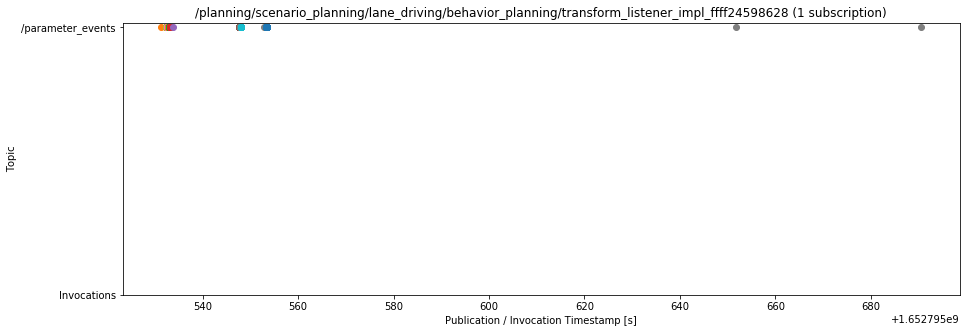

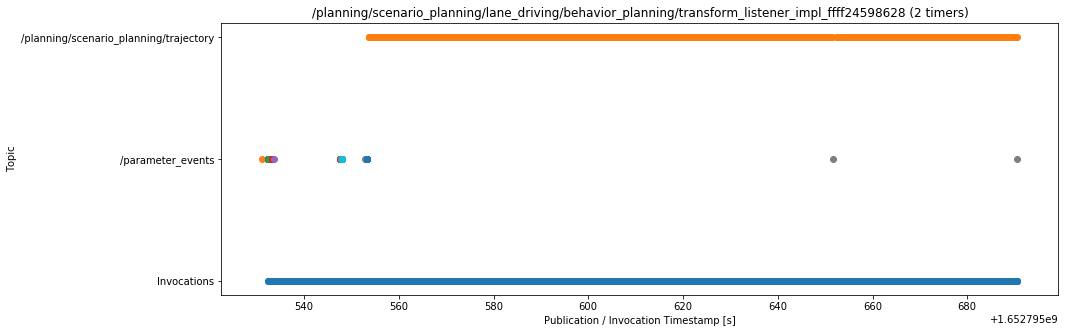

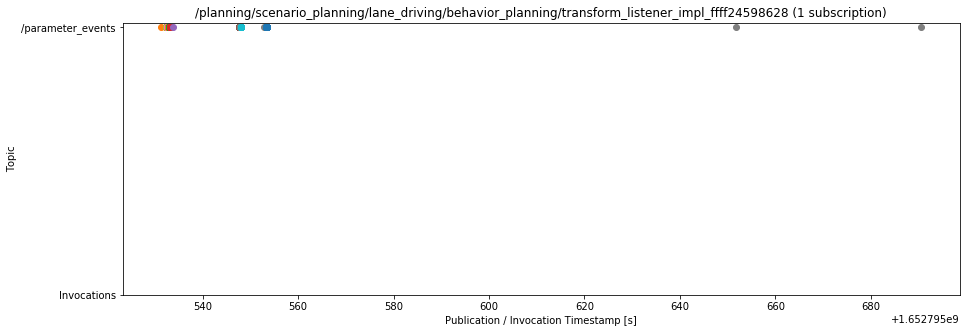

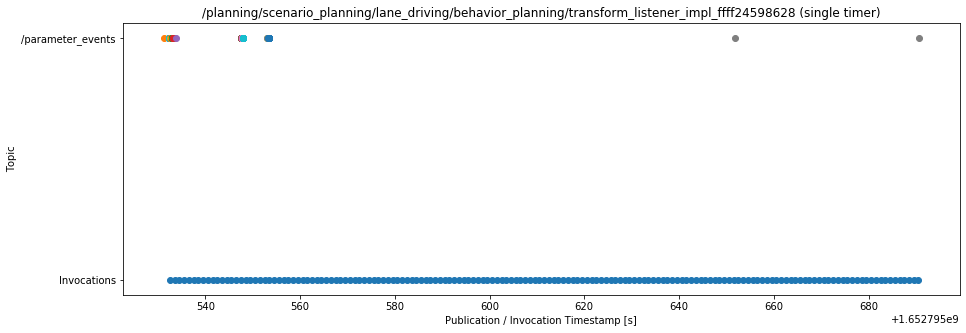

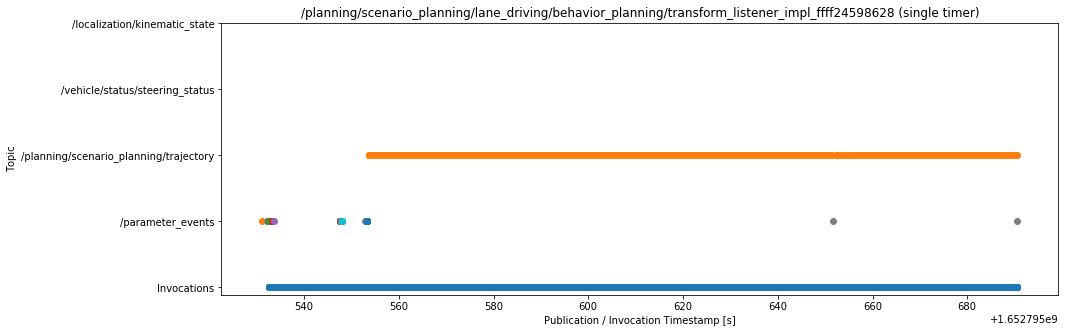

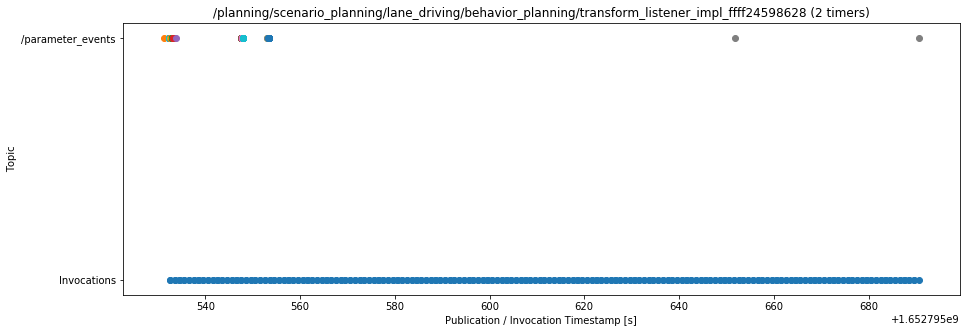

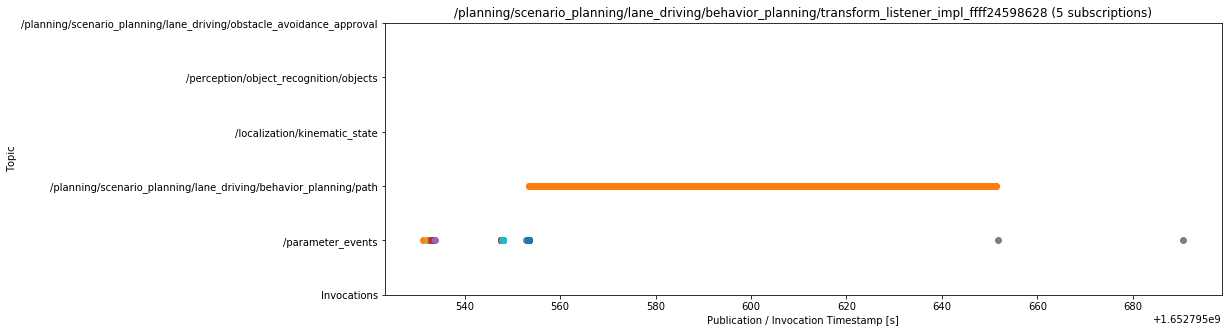

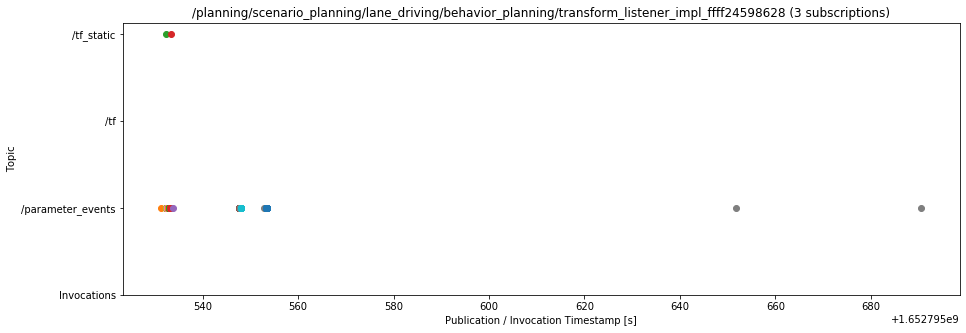

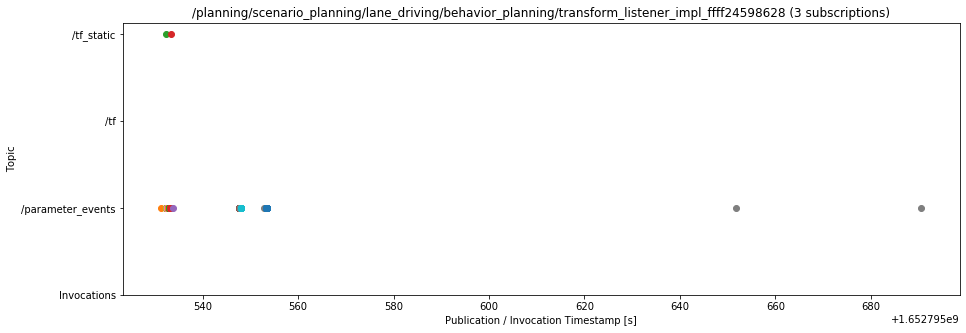

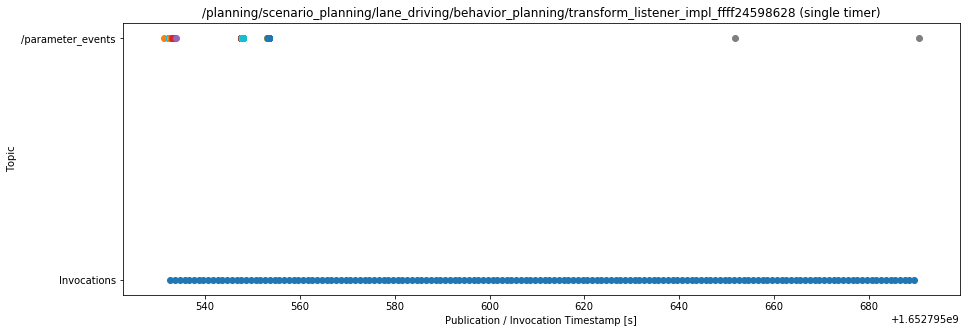

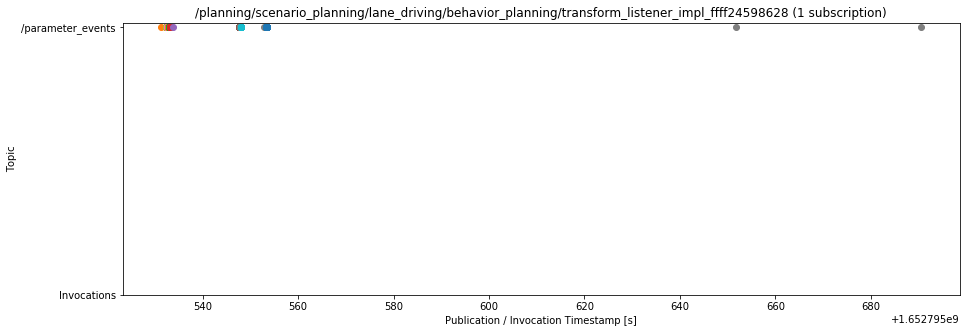

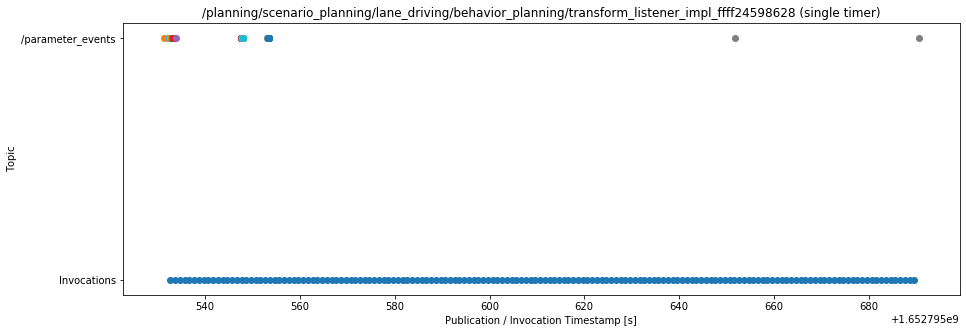

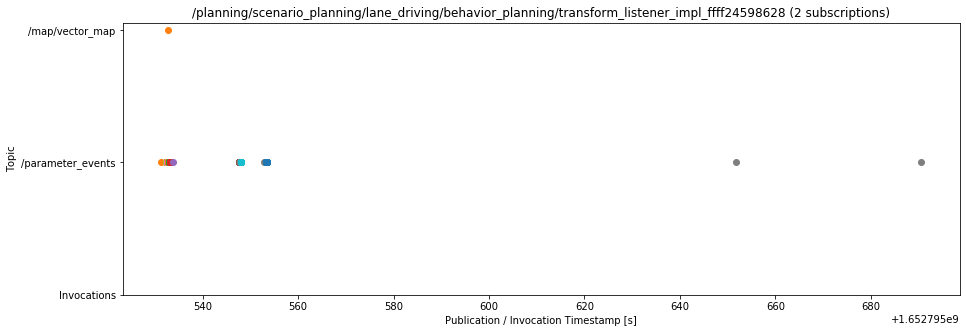

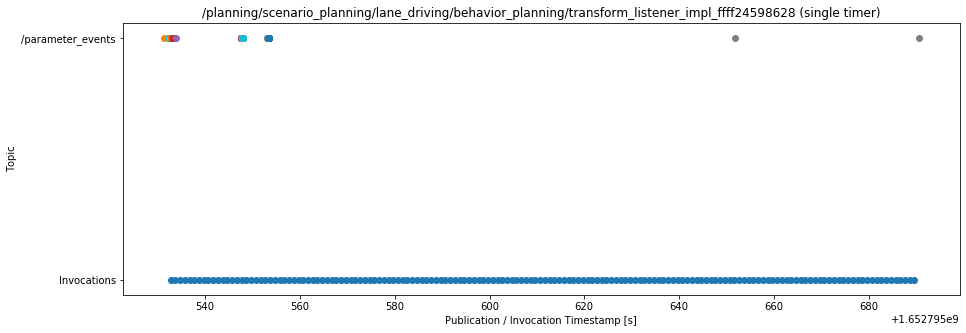

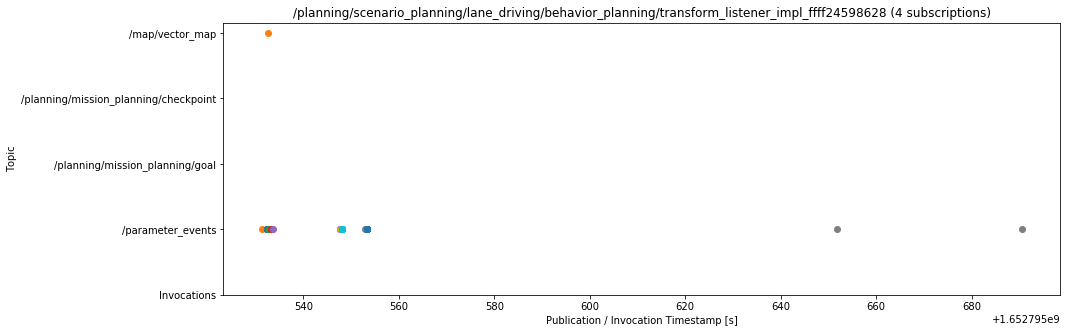

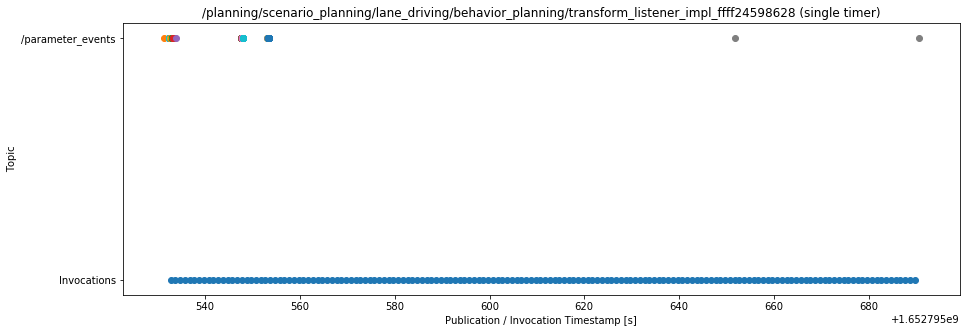

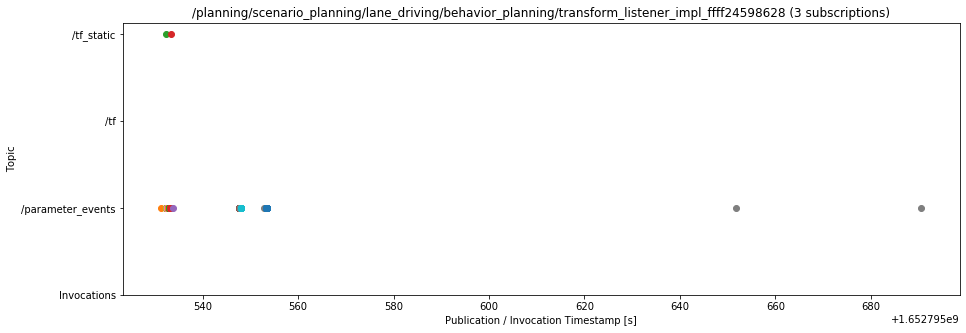

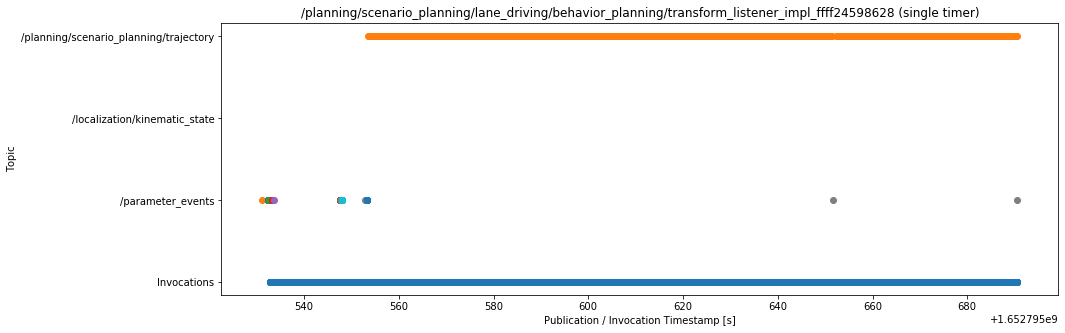

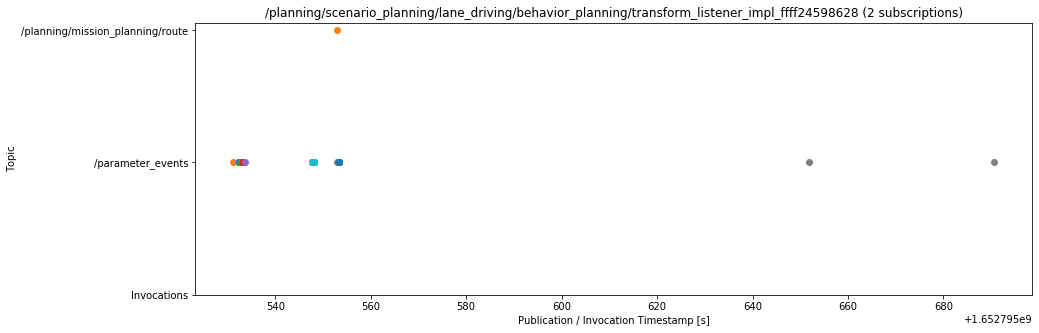

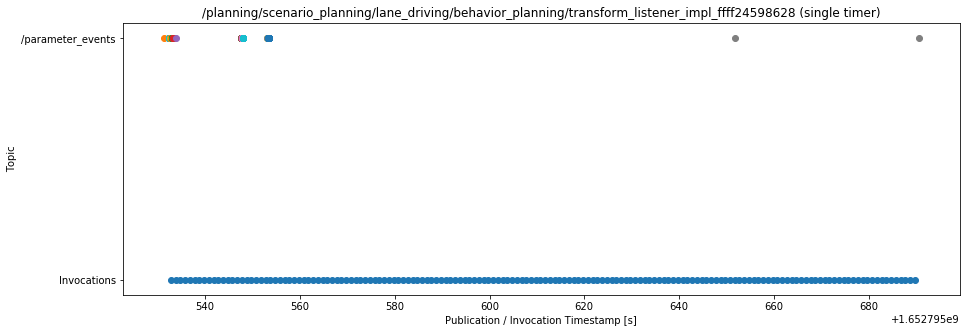

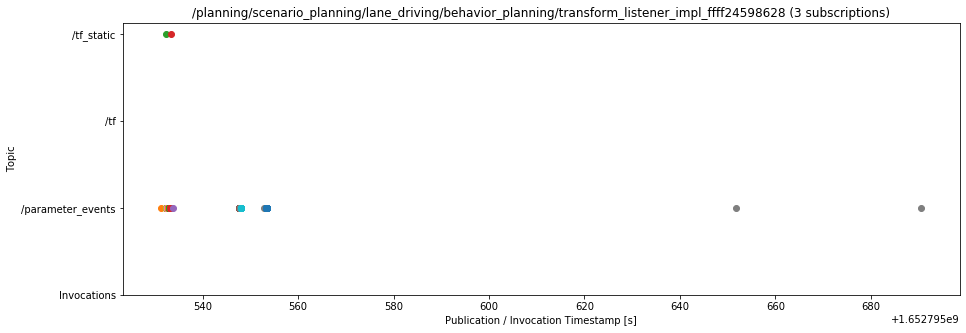

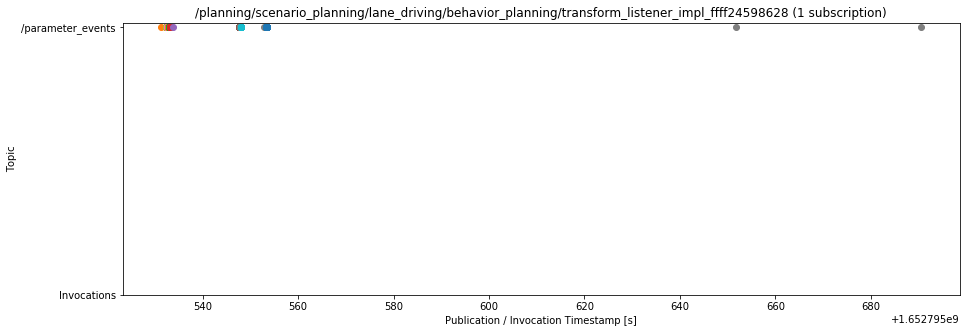

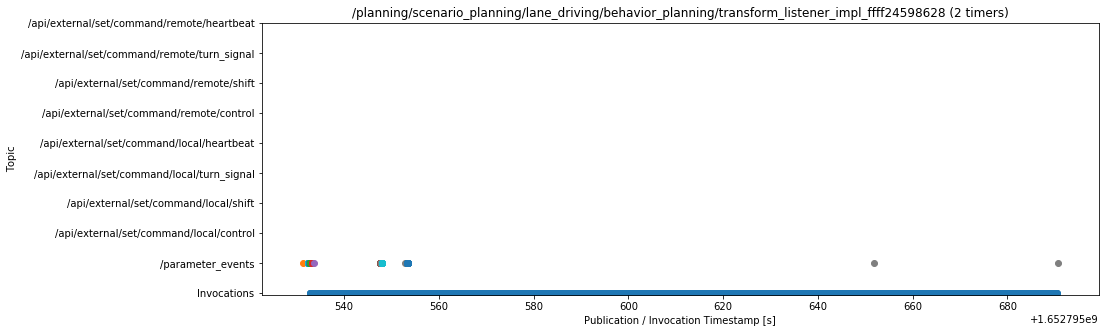

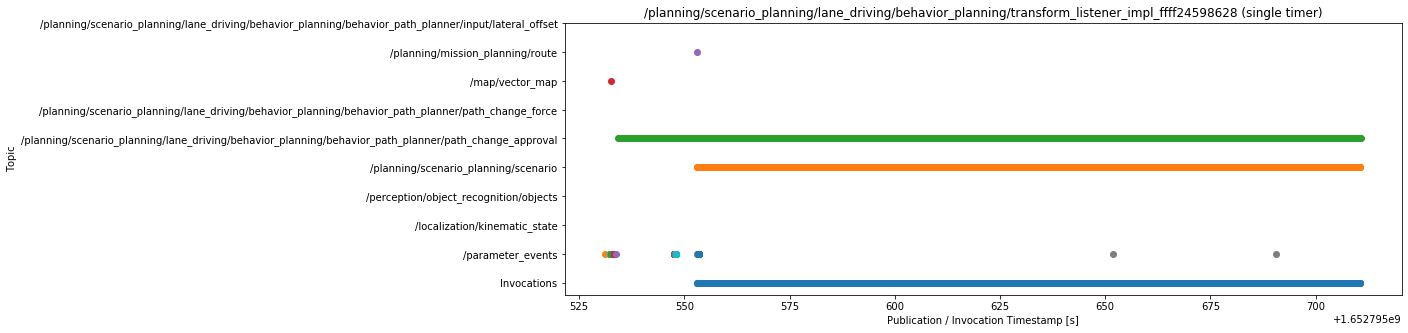

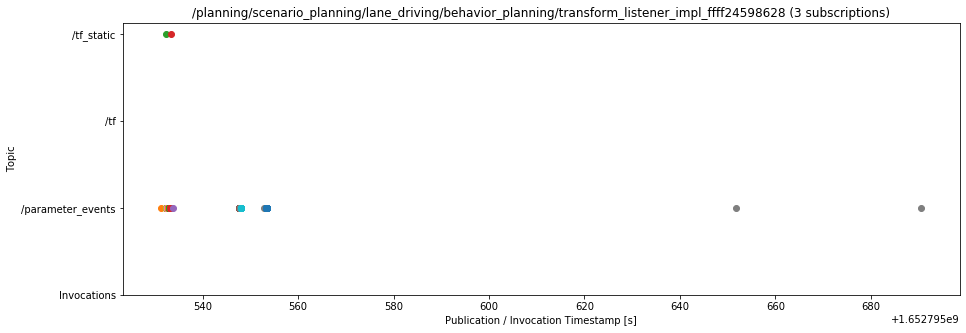

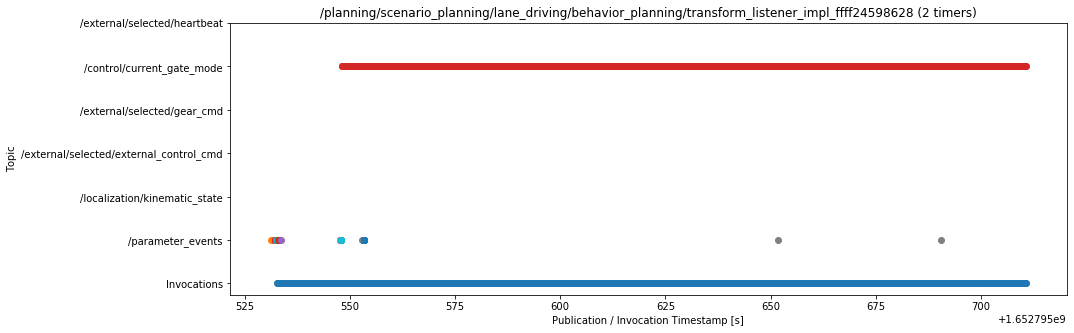

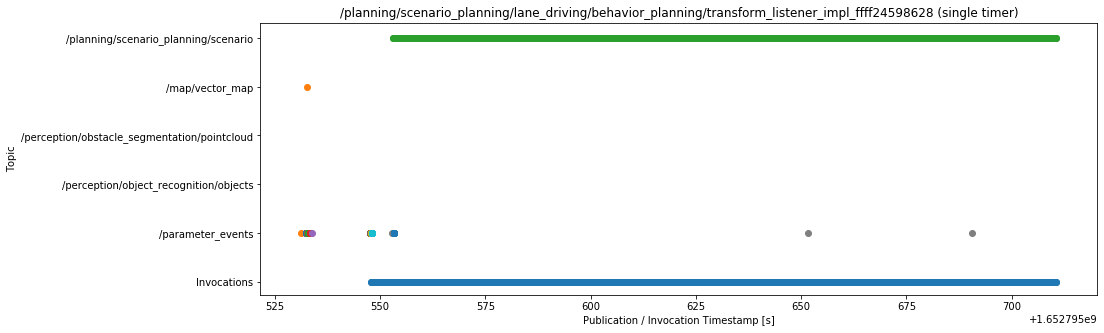

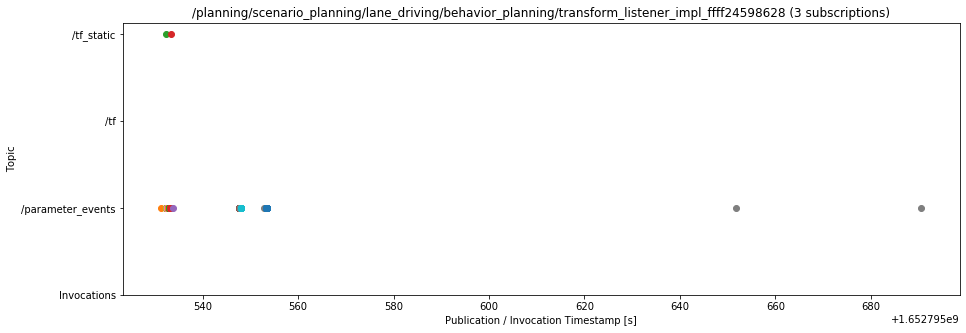

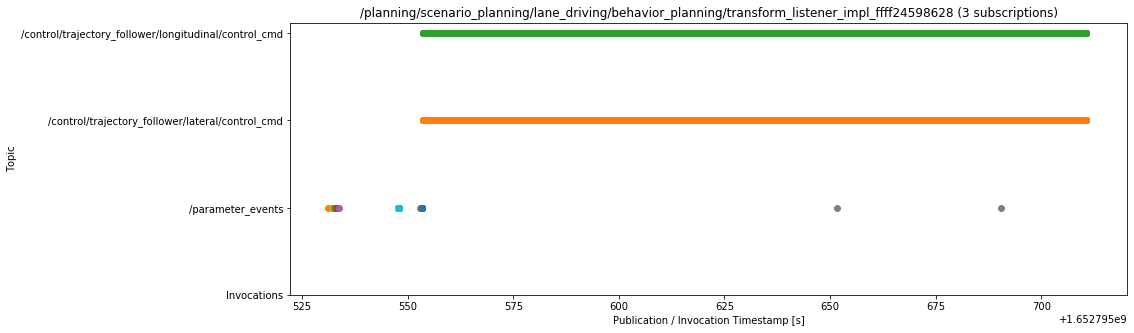

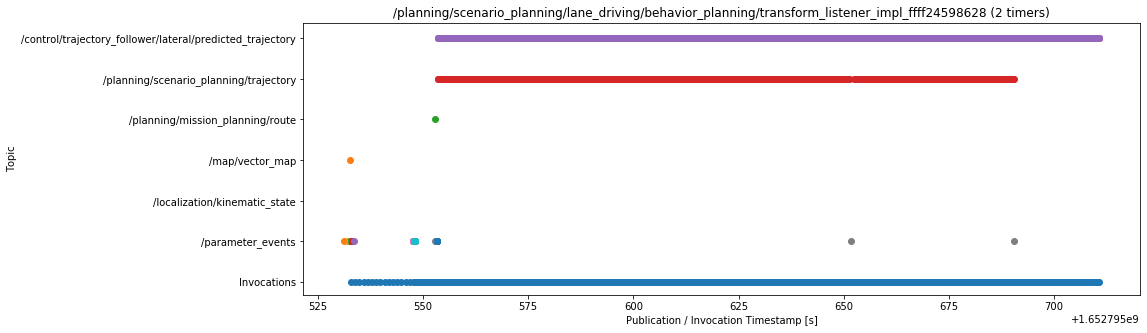

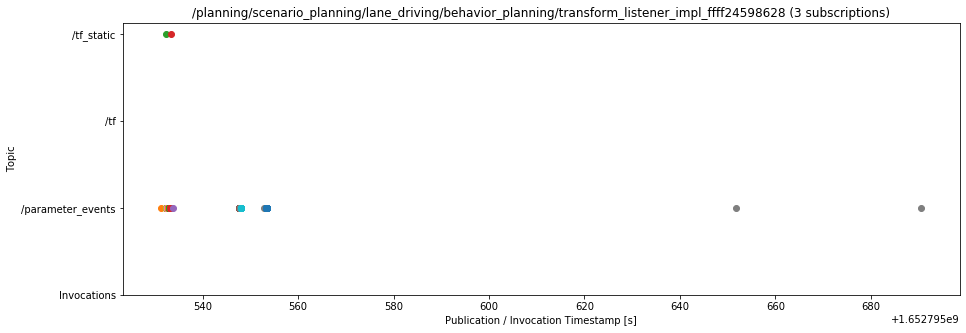

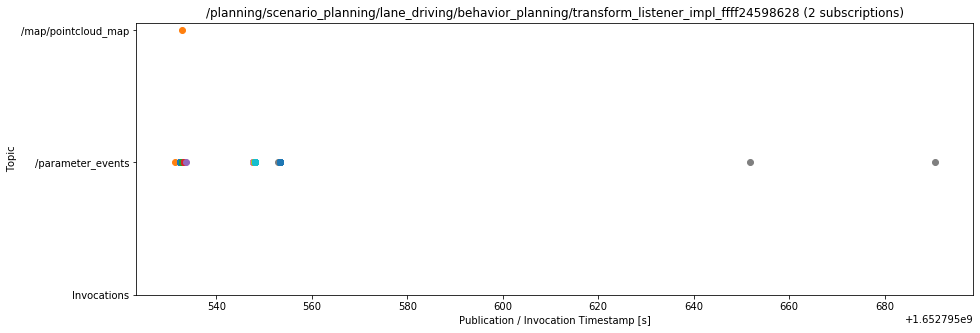

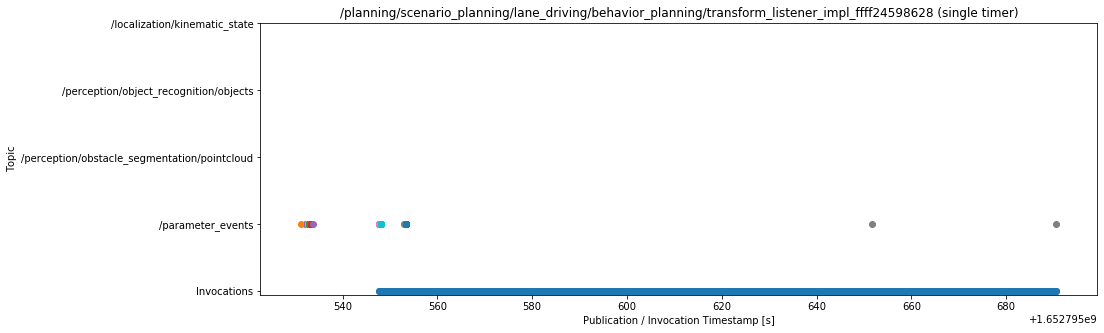

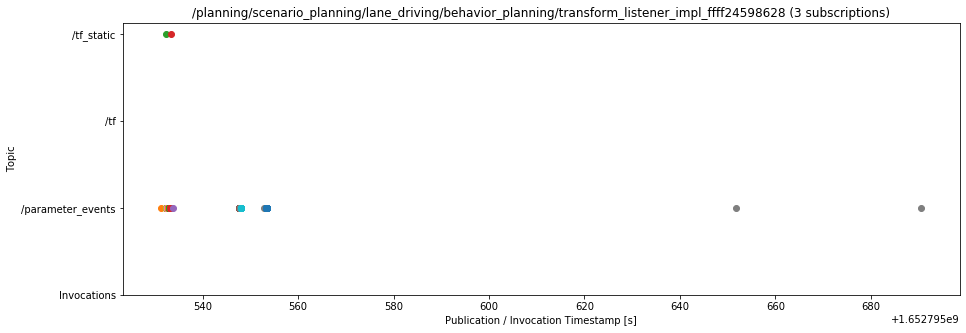

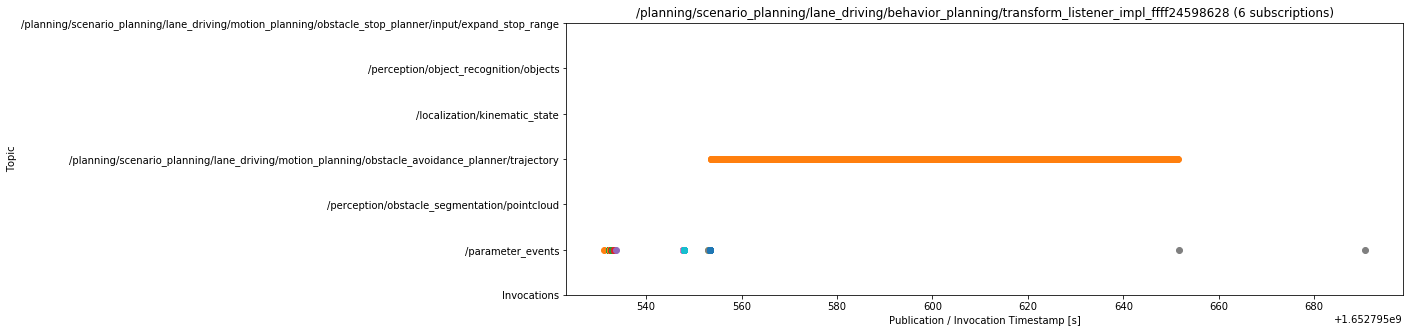

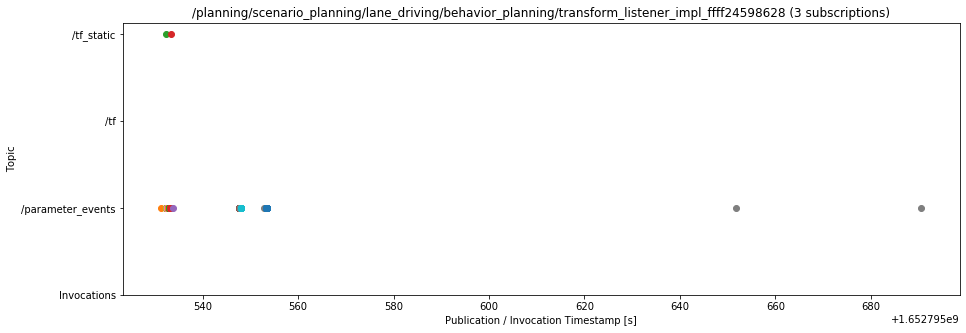

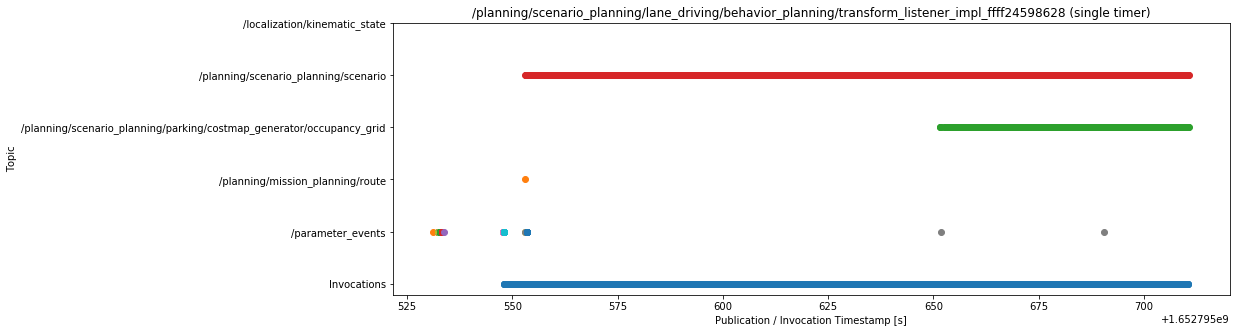

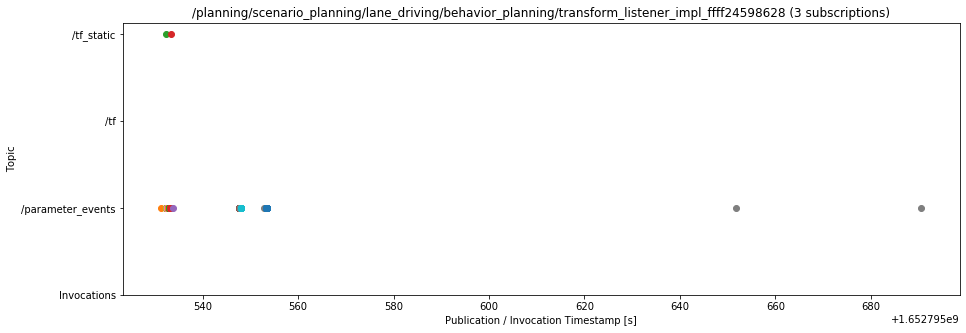

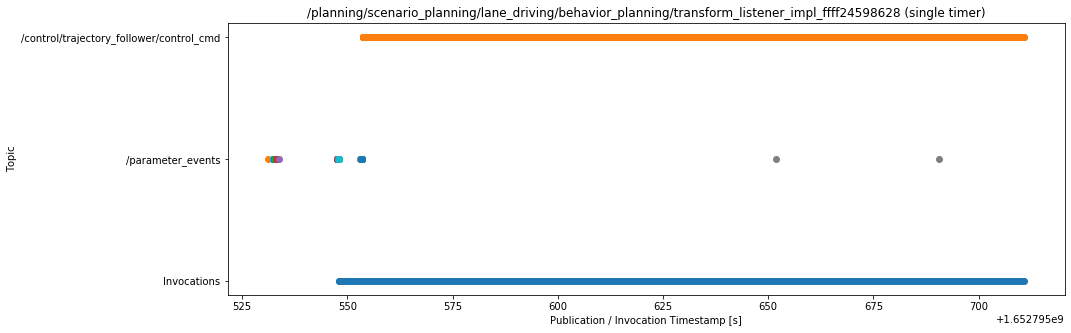

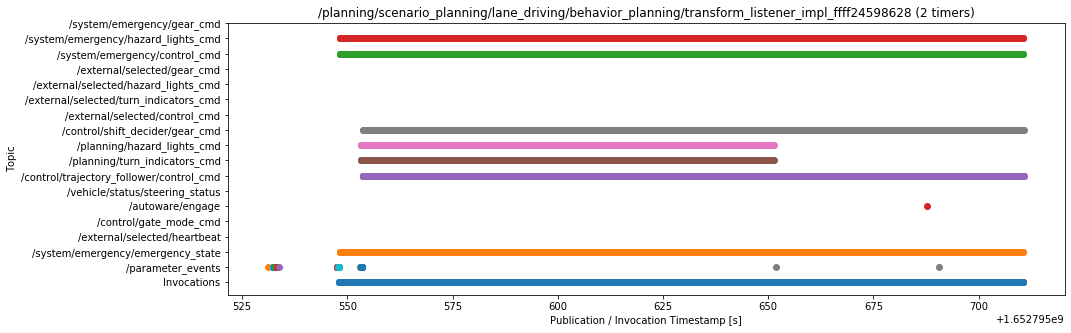

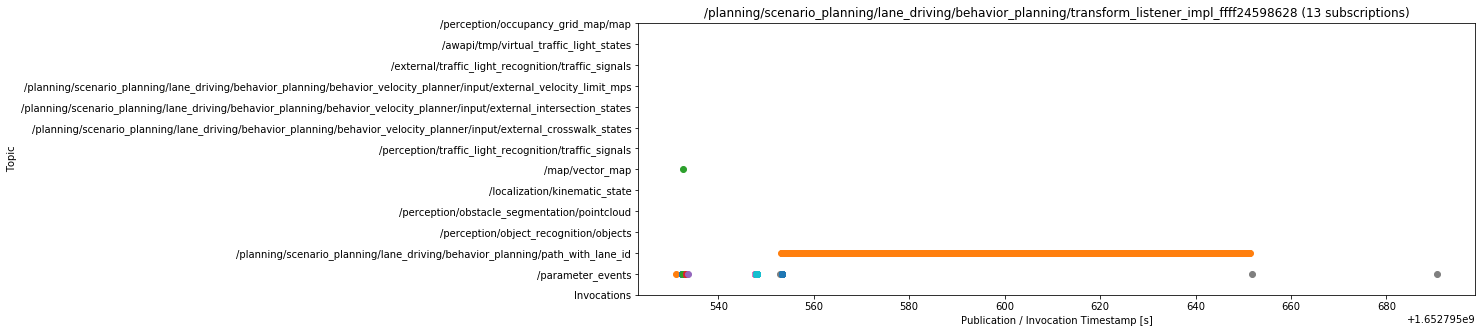

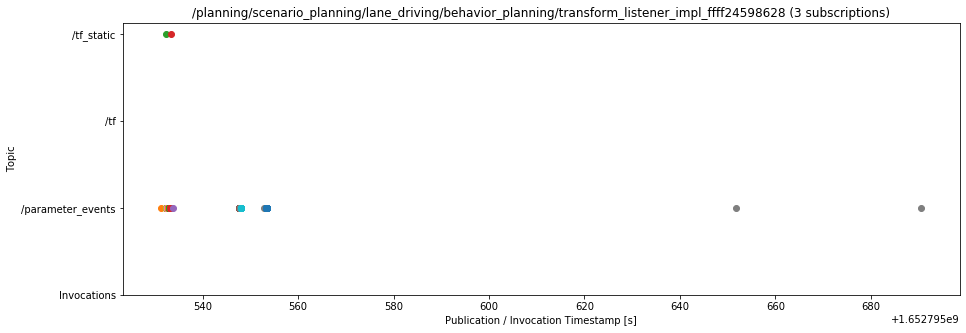

In [54]:
fig_dirname = "fig_pub_use"
os.makedirs(fig_dirname, exist_ok=True)
for node_i, (node, node_path, node_pub_use_dict) in enumerate(map(lambda node: (node, node_path, pub_use_delays[node.path]), nodes.values())):
    if len(node_pub_use_dict['pubs']) == 0:
        print(f"Skipping {node_path}, no publications")
        continue

    fig = plt.figure(figsize=(15,5))
    ax: plt.Axes = fig.add_subplot()

    max_pubs_per_topic = max(len(pubs) for pubs in node_pub_use_dict['pubs'].values())
    topic_names, topic_pubs = (zip(*node_pub_use_dict['pubs'].items()))

    vmin = 0; vmax = max_pubs_per_topic * len(topic_names)

    ax.scatter(np.array(node_pub_use_dict["invocations"]) * 1e-9, [0] * len(node_pub_use_dict["invocations"]))#, c=0, vmin=vmin, vmax=vmax)

    for topic_i, (topic_name, pubs) in enumerate(zip(topic_names, topic_pubs)):
        for pub_i, (pub_name, timestamps) in enumerate(pubs.items()):
            ax.scatter(np.array(timestamps) * 1e-9, [topic_i + 1] * len(timestamps))#, c=topic_i * max_pubs_per_topic, vmin=vmin, vmax=vmax)
    
    t = node.timers
    if t:
        if len(t) == 1:
            trigger_str = "single timer"
        else:
            trigger_str = f"{len(t)} timers"
    else:
        n_subs = len(node.subscriptions)
        trigger_str = f"{n_subs} subscription{'s' if n_subs != 1 else ''}"

    ax.set_xlabel("Publication / Invocation Timestamp [s]")
    ax.set_ylabel("Topic")
    ax.set_yticks(range(1+len(topic_names)))
    ax.set_yticklabels(("Invocations", *topic_names))
    ax.set_title(f"{node_path} ({trigger_str})")
    plt.savefig(os.path.join(fig_dirname, f"{node_i:06}{node_path}".replace('/','-')))